# TEAM-SASA     
### Initial POC and EDA for Rappler Website

In [ ]:
from IPython.display import Video
Video('team-sasa.mp4', embed=True, html_attributes='muted loop autoplay', width=1000, height=600)

# Work Summary
### Each member was assigned to scrape a News Website

### Team Accomplishments:
- Inquirer
- ABS-CBN
- Rappler


In [16]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains

from time import sleep

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [17]:
!which chromedriver

/usr/local/bin/chromedriver


## HELPER CLASS - WEBSCRAPING

In [18]:
DRIVER_PATH = '/usr/local/bin/chromedriver'

class RapplerScraper:

    def __init__(self, search_url):
        self.urls = []
        self.search_url = search_url
        self.driver = webdriver.Chrome(DRIVER_PATH)

    def crawl(self):
        self.driver.get(self.search_url)
        totalpages = self.get_total_pages()
        self.get_pages(totalpages)

    def get_driver(self):
        return self.driver
        
    def get_urls(self):
        return self.urls

    def get_urls_count(self):
        return len(self.urls)

    def get_total_pages(self):
        pages = self.driver.find_elements(By.CSS_SELECTOR, 'div.gsc-cursor-page')
        return len(pages)

    def add_urls(self, page):
        print(f'Start crawling article URLs for page {page}...')
        alinks = self.driver.find_elements(By.CSS_SELECTOR, 'a.gs-title')
        for a in alinks:
            link = a.get_attribute('href')
            if (link != None) and (link not in self.urls):
                self.urls.append(link)
        print('Done.')

    def get_pages(self, totalpages):
        print(f'Total number of pages to crawl: {totalpages}', end='\n\n')
        # Page 1
        self.add_urls(1)
        # Page 2 onwards
        self.driver.maximize_window()
        for p in range(1, totalpages):
            self.driver.execute_script('window.scrollBy(0, document.body.scrollHeight)', '') 
            pages = self.driver.find_elements(By.CSS_SELECTOR, 'div.gsc-cursor-page')
            pages[p].click()
            sleep(5)
            self.add_urls(p+1)

    def close_popups(self):
        try:
            self.driver.find_element(By.XPATH, '//*[@id="survicate-box"]/div/div/div[3]/div[2]/button').click()
        except:
            pass
        try:
            self.driver.find_element(By.XPATH, '//*[@id="onesignal-slidedown-cancel-button"]').click()
        except:
            pass
        try:
            # Close footer ads
            self.driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[16]//following::div/p/span').click()
        except:
            pass

    def scrape_data(self, url):
        ### PREPARE ARTICLE URL
        self.driver.get(url)
        sleep(15)

        ### PREPARE TITLE
        title = self.driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[16]/div[5]/div[2]/div[2]/div/div/h1')
        title = title.text
        print(f'\n[Title]\n{title}')

        ### PREPARE PUBLISHED DATE
        pubdate = self.driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[16]/div[5]/div[2]/div[2]/div/div/p/time')
        pubdate = pubdate.text
        print(f'\n[Date Pulished]\n{pubdate}')

        ### PREPARE AUTHOR NAME
        author = self.driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[16]/div[5]/div[2]/div[3]/div/a')
        author = author.text
        print(f'\n[Author]\n{author}')

        # Try closing popups before clicking 'SEE THE RESULTS' button
        sleep(2)
        self.close_popups()

        ### PREPARE ARTICLE CONTENT
        article = self.driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[16]/div[6]')
        article_content = article.text.replace('ADVERTISEMENT','').replace('How did this story make you feel?', '').replace('INSPIRED','')\
            .replace('HAPPY','').replace('AMUSED','').replace('NEUTRAL','').replace('ANNOYED','').replace('SAD','').replace('ANGRY','')\
            .replace('AFRAID','').replace('SEE THE RESULTS','').replace(' \n','').replace('\n ','').replace('\n\n','').replace('  ','') 
        print(f'\n[Content]\n{article_content}')

        ### PREPARE SENTIMENT RESULTS
        # Scroll to 'SEE THE RESULTS' button then simulate click to get sentiment results
        sleep(3)
        sentiment_classname = self.driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[16]/div[6]/div[4]/following::div').get_attribute('class')
        self.driver.execute_script(f'document.getElementsByClassName("{sentiment_classname}").scrollIntoView', '')
        
        # Automate click event to get sentiment results
        sentiment_index = 0
        for i in range(100):
            try:
                btn_sentiment = self.driver.find_element(By.XPATH, f'//*[@id="__next"]/div/div[16]/div[6]/div[4]/div[{i}]/div/div/span')
                if btn_sentiment.text.upper() == 'SEE THE RESULTS':
                    sleep(2)
                    self.close_popups()
                    action = ActionChains(self.driver)
                    action.move_to_element(btn_sentiment).click().perform()
                    # btn_sentiment.click()
                    sentiment_index = i
                    break
            except:
                pass

        sleep(3)
        # Clean some sentiment texts
        sentiment_results = self.driver.find_element(By.XPATH, f'//*[@id="__next"]/div/div[16]/div[6]/div[4]/div[{sentiment_index}]/div')
        sentiment_results = sentiment_results.text.replace('HOW OTHERS ARE FEELING', '').replace(' \n','').replace('\n ','').replace(' ARE ','-')
        # Convert each line of sentiment text to a list item
        sentiment_results = list(filter(None, sentiment_results.split('\n')))
        # Make a key-value pair of sentiment text and store it as dictionary object
        sentiment_results = {s.split('-')[1] : float(s.split('-')[0].split('%')[0])*.01 for s in sentiment_results}
        # Add a 0% value for sentiment key that does not have results in the current article and store as 'other sentiments'
        sentiment_keys = ['INSPIRED', 'HAPPY', 'AMUSED', 'NEUTRAL', 'ANNOYED', 'SAD', 'ANGRY', 'AFRAID']
        sentiment_others = {k : 0. for k in sentiment_keys if k not in sentiment_results}
        # Combine 'other sentiment dictionary' to the 'sentiment result dictionary' 
        sentiment_results = {**sentiment_results, **sentiment_others}
        print(f'\n[Sentiment]')
        print(sentiment_results)

        ### GET SENTIMENT RESULTS FROM ARTICLE
        return {'urls':url, 'titles':title, 'authors':author, 'published_dates':pubdate, 'articles_content':article_content, 'sentiments':sentiment_results}
    

# RUN WEB SCRAPING

In [19]:
KEYWORD = 'philippines+covid+vaccine'
SEARCH_URL = f'https://r3.rappler.com/?option=com_rappler&task=search&language=english&q={KEYWORD}'

scraper = RapplerScraper(SEARCH_URL)
scraper.crawl()

dataset = []
print(f'\nTotal number of articles: {scraper.get_urls_count()}')
for i,url in enumerate(scraper.get_urls()):
    try:
        print(f'\n\n\n[{i+1}]{" ":>5}SCRAPING DATA  ~>  {url}')
        data = scraper.scrape_data(url)
        dataset.append(data)
    except Exception as e:
        print(f'SCRAPING ERROR: {e}')
        pass

scraper.get_driver().quit()

Total number of pages to crawl: 10

Start crawling article URLs for page 1...
Done.
Start crawling article URLs for page 2...
Done.
Start crawling article URLs for page 3...
Done.
Start crawling article URLs for page 4...
Done.
Start crawling article URLs for page 5...
Done.
Start crawling article URLs for page 6...
Done.
Start crawling article URLs for page 7...
Done.
Start crawling article URLs for page 8...
Done.
Start crawling article URLs for page 9...
Done.
Start crawling article URLs for page 10...
Done.

Total number of articles: 98



[1]     SCRAPING DATA  ~>  https://www.rappler.com/newsbreak/explainers/why-covid-19-vaccines-not-arrive-philippines

[Title]
Here’s why COVID-19 vaccines haven’t arrived in the Philippines yet

[Date Pulished]
FEB 18, 2021 9:22 AM PHT

[Author]
SOFIA TOMACRUZ

[Content]
MANILA, PHILIPPINES
The Philippine government needs a key measure on indemnification funds to be signed into law
Philippine pandemic officials announced the delivery of the count

# EDA

In [30]:
df = pd.DataFrame(dataset)
df

urls  \
0   https://www.rappler.com/newsbreak/explainers/w...   
1   https://www.rappler.com/newsbreak/iq/timeline-...   
2   https://www.rappler.com/nation/philippines-rec...   
3   https://www.rappler.com/nation/philippines-rec...   
4   https://www.rappler.com/nation/philippines-beg...   
..                                                ...   
69  https://www.rappler.com/nation/filipino-muslim...   
70  https://www.rappler.com/nation/duterte-pleads-...   
71  https://www.rappler.com/nation/duterte-signs-l...   
72  https://www.rappler.com/nation/duterte-taps-ca...   
73  https://www.rappler.com/nation/octa-warns-astr...   

                                               titles                 authors  \
0   Here’s why COVID-19 vaccines haven’t arrived i...          SOFIA TOMACRUZ   
1   TIMELINE: The Philippines’ 2021 COVID-19 vacci...          SOFIA TOMACRUZ   
2   Philippines receives first COVID-19 vaccine de...          SOFIA TOMACRUZ   
3   After initial delay, Philippines to receive As...          SOFIA TOMACRUZ   
4   Philippines begins legally rolling out first C...          SOFIA TOMACRUZ   
..                                                ...                     ...   
69  Filipino Muslim leaders endorse COVID-19 vacci...  PATERNO R. ESMAQUEL II   
70  Duterte pleads with Xi Jinping: Prioritize PH ...          SOFIA TOMACRUZ   
71  Duterte signs law speeding up vaccine purchase...              PIA RANADA   
72              Duterte taps Galvez as 'vaccine czar'              PIA RANADA   
73  Expert warns 17M AstraZeneca doses 'ineffectiv...          BONZ MAGSAMBOL   

             published_dates  \
0   FEB 18, 2021 9:22 AM PHT   
1    FEB 4, 2021 7:43 PM PHT   
2   FEB 28, 2021 4:16 PM PHT   
3    MAR 3, 2021 2:41 PM PHT   
4    MAR 1, 2021 9:40 AM PHT   
..                       ...   
69  FEB 4, 2021 10:37 PM PHT   
70  JUL 27, 2020 5:47 PM PHT   
71  FEB 26, 2021 8:25 PM PHT   
72   NOV 2, 2020 7:13 PM PHT   
73   MAR 3, 2021 5:54 PM PHT   

                                     articles_content  \
0   MANILA, PHILIPPINES\nThe Philippine government...   
1   MANILA, PHILIPPINES\n(UPDATED) On March 1, the...   
2   MANILA, PHILIPPINES\n(3rd UPDATE) The arrival ...   
3   MANILA, PHILIPPINES\n(UPDATED) Malacañang says...   
4   MANILA, PHILIPPINES\n(3rd UPDATE) Dr. Gerardo ...   
..                                                ...   
69  MANILA, PHILIPPINES\n'Any substance that will ...   
70  MANILA, PHILIPPINES\nPresident Rodrigo Duterte...   
71  MANILA, PHILIPPINES\nThe law creates a P500-mi...   
72  MANILA, PHILIPPINES\nCarlito Galvez Jr, who is...   
73  MANILA, PHILIPPINES\n(1st UPDATE) Father Nican...   

                                           sentiments  
0   {'ANGRY': 0.42, 'ANNOYED': 0.23, 'SAD': 0.11, ...  
1   {'NEUTRAL': 0.29, 'HAPPY': 0.21, 'INSPIRED': 0...  
2   {'HAPPY': 0.22, 'NEUTRAL': 0.18, 'ANGRY': 0.18...  
3   {'HAPPY': 0.6, 'AMUSED': 0.11, 'NEUTRAL': 0.11...  
4   {'HAPPY': 0.31, 'NEUTRAL': 0.19, 'ANGRY': 0.12...  
..                                                ...  
69  {'HAPPY': 0.5700000000000001, 'AMUSED': 0.29, ...  
70  {'ANGRY': 0.3, 'NEUTRAL': 0.21, 'SAD': 0.14, '...  
71  {'HAPPY': 0.26, 'NEUTRAL': 0.2, 'ANNOYED': 0.1...  
72  {'ANGRY': 0.34, 'ANNOYED': 0.16, 'AMUSED': 0.1...  
73  {'SAD': 0.31, 'AFRAID': 0.29, 'ANNOYED': 0.11,...  

[74 rows x 6 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   urls              85 non-null     object
 1   titles            85 non-null     object
 2   authors           85 non-null     object
 3   published_dates   85 non-null     object
 4   articles_content  85 non-null     object
 5   sentiments        85 non-null     object
dtypes: object(6)
memory usage: 4.1+ KB


In [7]:
df.describe().T

count unique  \
urls                85     85   
titles              85     85   
authors             85     13   
published_dates     85     85   
articles_content    85     85   
sentiments          85     85   

                                                                top freq  
urls              https://www.rappler.com/nation/philippine-gove...    1  
titles            Duterte approves prepayment for Pfizer's COVID...    1  
authors                                              SOFIA TOMACRUZ   41  
published_dates                            JAN 13, 2021 3:32 PM PHT    1  
articles_content  MANILA, PHILIPPINES\nA timeline shared by Heal...    1  
sentiments        {'ANGRY': 0.2, 'AMUSED': 0.2, 'ANNOYED': 0.15,...    1

In [20]:
df.isna().sum()

urls                0
titles              0
authors             0
published_dates     0
articles_content    0
sentiments          0
dtype: int64

In [25]:
### Save a CSV dataset
df.to_csv(f'rappler_{KEYWORD}.csv', index=False)

# WORDCLOUD

In [26]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np

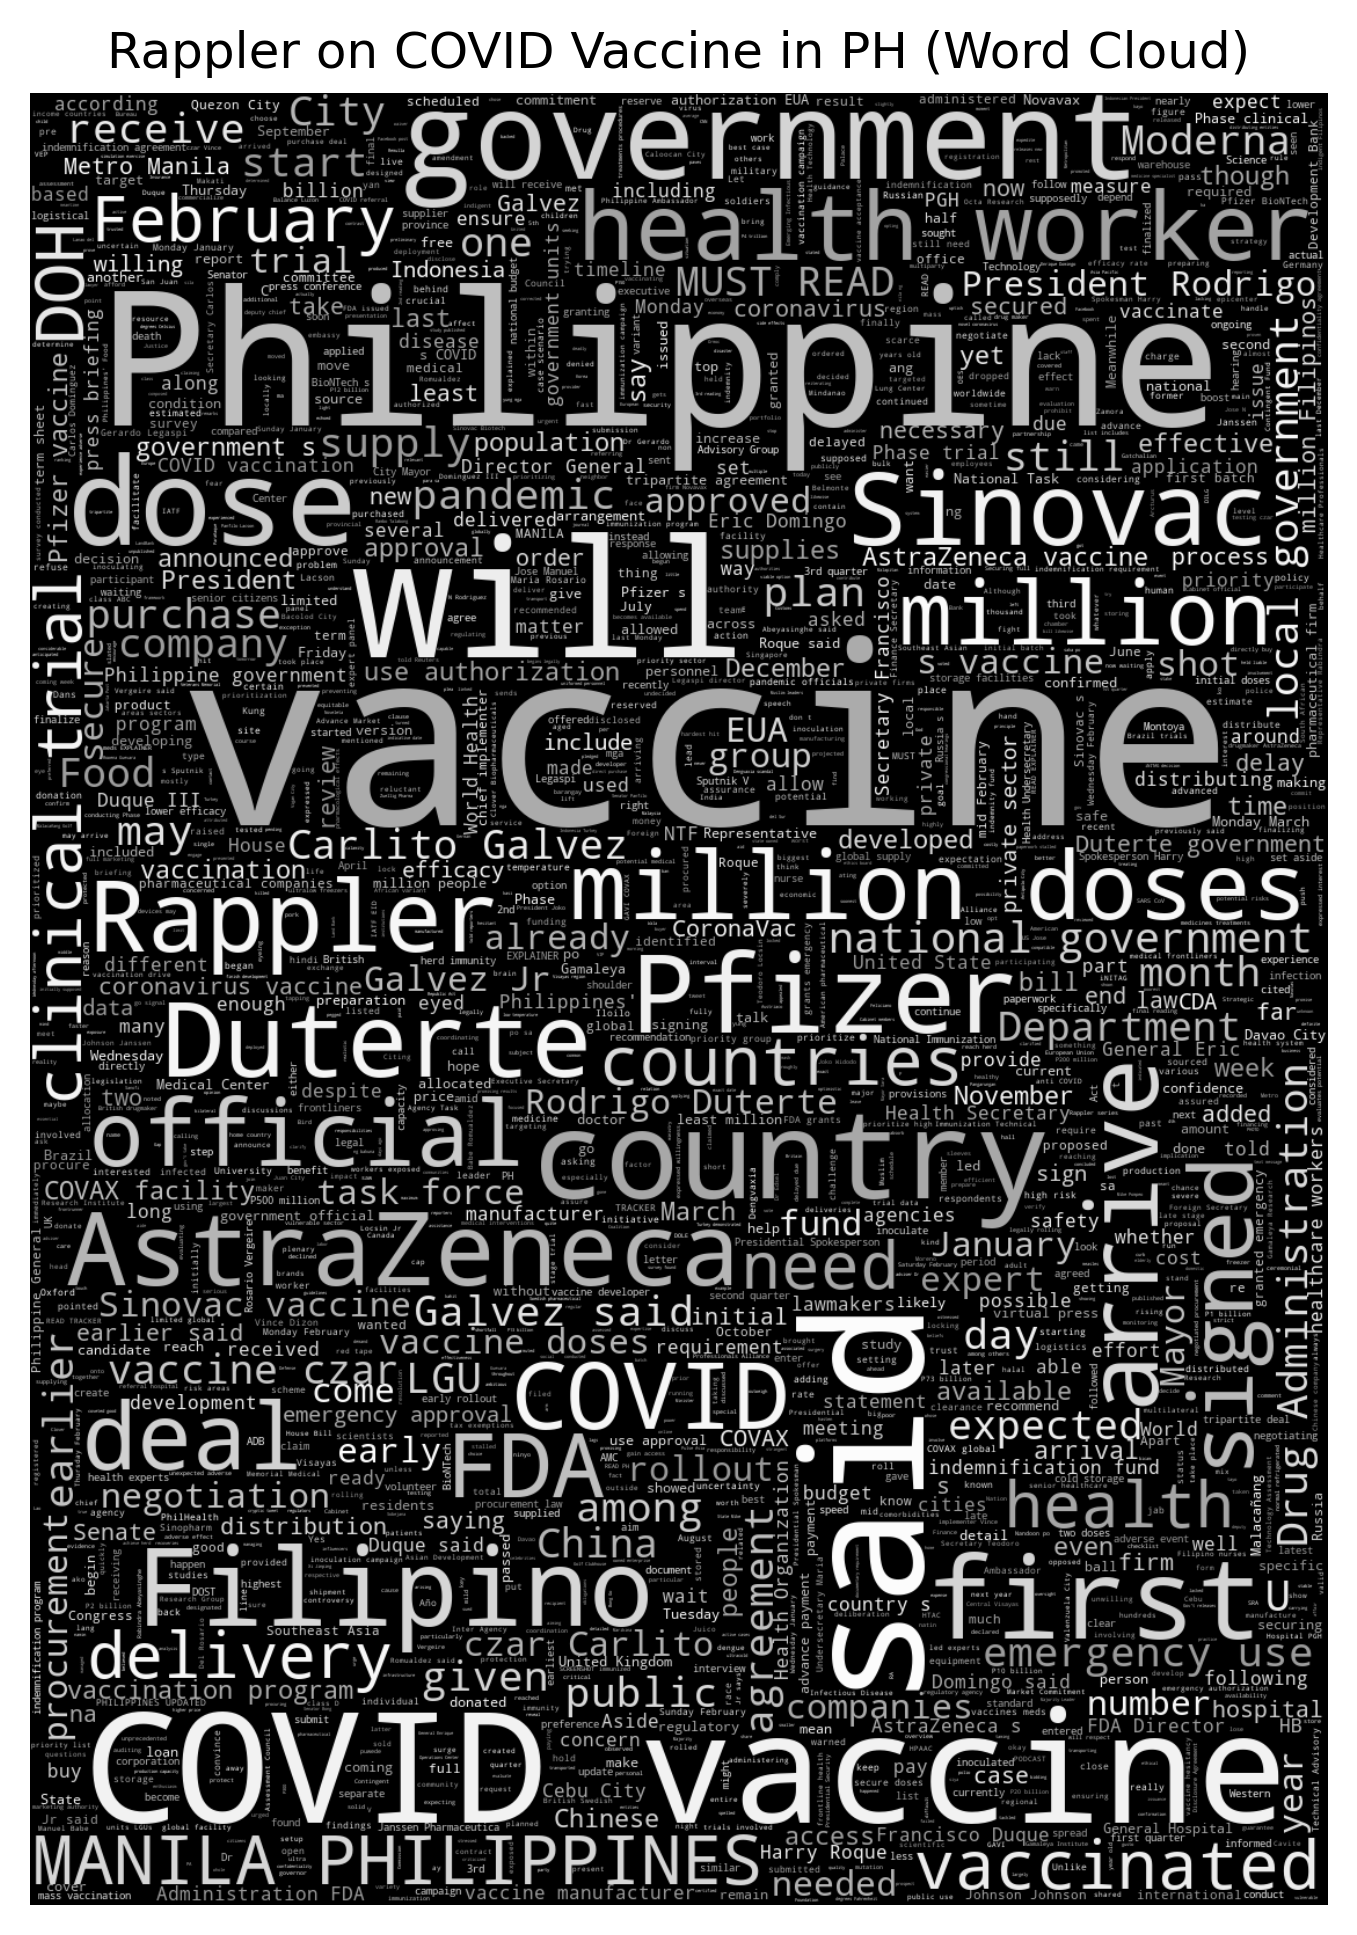

In [27]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % np.random.randint(60, 100)

mask = np.array(Image.open('bg.png'))

words = ' '.join(df['articles_content'].tolist())
wordcloud = WordCloud(background_color='black', max_words=2000, width=1024, height=720, mask=mask)
wordcloud.generate(words)

plt.figure(figsize=(20, 8), dpi=300)
plt.title('Rappler on COVID Vaccine in PH (Word Cloud)')
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=42), interpolation='bilinear')
plt.axis('off')
plt.show()